# PUHEKOMENNOT TUNNISTAMINEN ÄÄNITTEISTÄ
Tehtävä: Rakenna malli, joka tunnistaa yksinkertaisia puhuttuja komentoja

Aineisto: [Speech Commands Dataset](https://www.tensorflow.org/datasets/catalog/speech_commands)

#### Aineisto on ladattu ja purettu testi/treeni/validaatio setteihin aineiston mukana tulevien readme-tiedostojen mukaan:
- README tiedostossa oli kerrottu, että datasetin tiedostot kannattaa jakaa hajautusfunktiolla
- Hajautusfunktio oli erotellut tiedostot niiden nimen perusteella ja antanut listan tiedostoista, joiden tulisi olla testi, treeni, tai validaatio aineistossa.
- Kirjoitimme Python -skriptin joka luki nämä tekstitiedostossa olevat tiedostonimet ja jakoi tiedostot oikeisiin aineistoihin.

Aineisto on jos siis eroteltu etukäteen.

#### Aineisto koostuu kahdestakymmenestä sanasta, joihin koulutus keskittyy:
- "Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", and "Nine".
- Jokaisesta sanasta esiintyy aineistossa yhden lukijan äänite viisi kertaa.

#### Lisäksi aineistossa tuli mukana luokittelut muille sanoille:
- "Bed", "Bird", "Cat", "Dog", "Happy", "House", "Marvin", "Sheila", "Tree", and "Wow".
- Jokainen sana esiintyy yhden noin kerran jokaiselta lukijalta.
- Nämä toissijaiset sanat on yhdistetty "unknown" luokitteluun.
     - Tämä tarkoittaa, että mallin tulisi keskittyä tunnistamaan, onko annettu ääni yksi avainsanoista, vai joku muu.

Lisäksi validaatiokansiossa oli luokittelu "background noise", jonka poistimme.

## Datasetin muodostaminen
Käytetään 

In [1]:
import tensorflow as tf
import keras
import keras.utils
import numpy as np
import pathlib

DATASET_PATH = 'split_dataset'
data_dir = pathlib.Path(DATASET_PATH)

# Load the dataset
train_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/train',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)
val_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/validation',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)
test_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/test',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)


2025-05-08 16:27:47.288902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746710867.444121    3377 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746710867.486046    3377 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746710867.812856    3377 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746710867.812907    3377 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746710867.812909    3377 computation_placer.cc:177] computation placer alr

NotFoundError: Could not find directory split_dataset/train

In [ ]:
label_names = np.array(train_ds.class_names)
print("label names:", label_names)

label names: ['Unknown' 'backward' 'down' 'eight' 'five' 'follow' 'forward' 'four' 'go'
 'learn' 'left' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'six' 'stop'
 'three' 'two' 'up' 'visual' 'yes' 'zero']


This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)
  print(example_labels[0])  # Print the label of the first example

(32, 16000)
(32, 26)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)


In [ ]:
print("label names:", label_names)

label names: ['Unknown' 'backward' 'down' 'eight' 'five' 'follow' 'forward' 'four' 'go'
 'learn' 'left' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'six' 'stop'
 'three' 'two' 'up' 'visual' 'yes' 'zero']


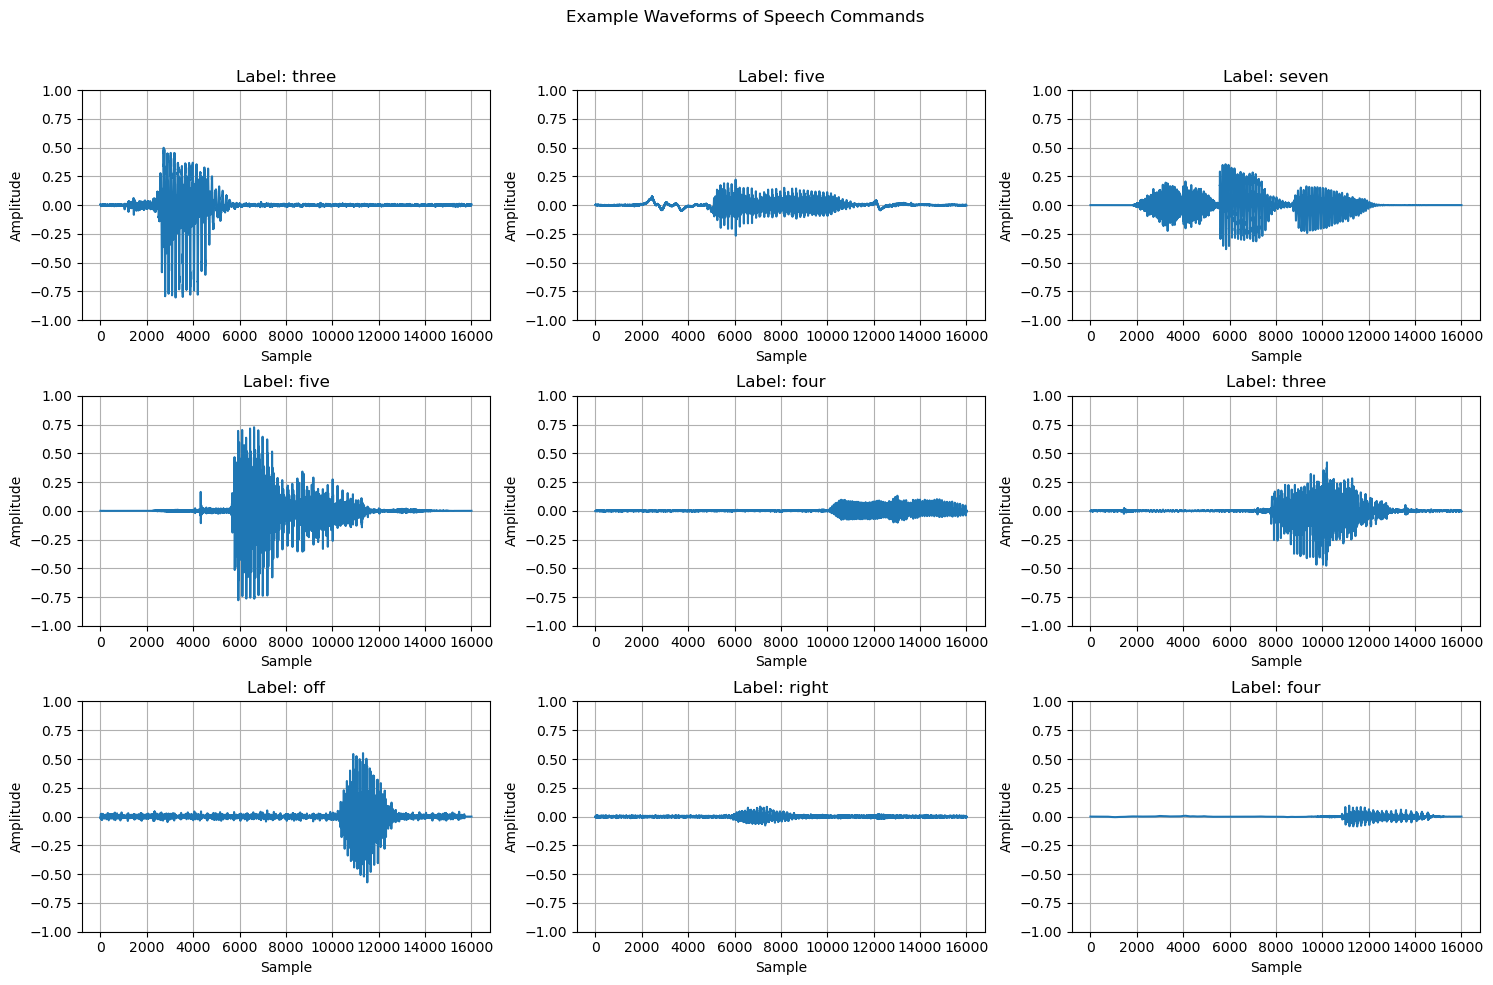

In [ ]:
import matplotlib.pyplot as plt

# Function to plot waveforms with their labels
def plot_waveforms(waveforms, labels, num_rows=3, num_cols=3):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    fig.suptitle('Example Waveforms of Speech Commands')
    
    # Flatten axes array for easier iteration
    axes = axes.flatten()
    
    for i, (waveform, label) in enumerate(zip(waveforms, labels)):
        if i >= num_rows * num_cols:
            break
            
        # Get the label index (where the value is 1.0)
        label_idx = tf.argmax(label).numpy()
        label_name = label_names[label_idx]
        
        # Plot the waveform
        axes[i].plot(waveform.numpy())
        axes[i].set_title(f'Label: {label_name}')
        axes[i].set_ylim([-1, 1])
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Plot examples from the training dataset
for example_batch, example_labels in train_ds.take(1):
    plot_waveforms(example_batch, example_labels)

## Muutetaan aaltomallit spektogrammeiksi

### Testataan eri spektogrammoja
Luodaan muutama funktio. Testataan eri spektrogrammoja

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
def get_mel_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Convert to mel scale
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=64,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=16000,
        lower_edge_hertz=0,
        upper_edge_hertz=8000)
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(mel_spectrogram.shape[-1:]))
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    return mel_spectrogram

In [ ]:
def plot_waveform_and_spectrograms(waveform):
    # Plot the waveform
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(waveform.numpy())
    plt.title('Waveform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot the spectrogram
    spectrogram = get_spectrogram(waveform)
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(spectrogram).numpy(), aspect='auto', cmap='inferno')
    plt.title('Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency bins')
    plt.colorbar()

    # Plot the mel spectrogram
    mel_spectrogram = get_mel_spectrogram(waveform)
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(mel_spectrogram).numpy(), aspect='auto', cmap='inferno')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Mel frequency bins')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

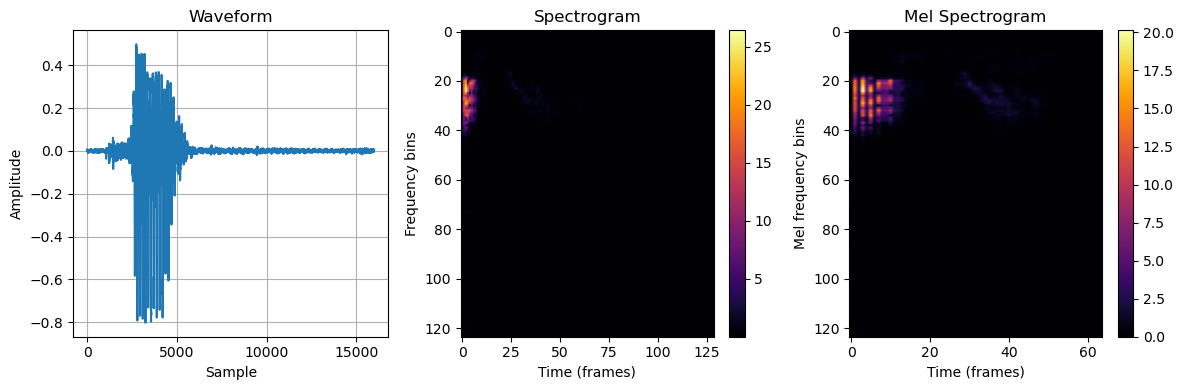

In [ ]:
plot_waveform_and_spectrograms(example_batch[0])


### Spektrogrammojen erot:
Mel Spektrogramma näyttää olevan venyneempi, ja tunnistaa matalammat äänet paremmin.

### Muutetaan koko datasetti spektrogrammamuotoon:

In [ ]:
def make_spectro_dataset(ds, spectrogram_fn):
    return ds.map(lambda audio, labels: (spectrogram_fn(audio), labels),
                  num_parallel_calls=tf.data.AUTOTUNE)

train_spectro_ds = make_spectro_dataset(train_ds, get_mel_spectrogram)
val_spectro_ds = make_spectro_dataset(val_ds, get_mel_spectrogram)
test_spectro_ds = make_spectro_dataset(test_ds, get_mel_spectrogram)

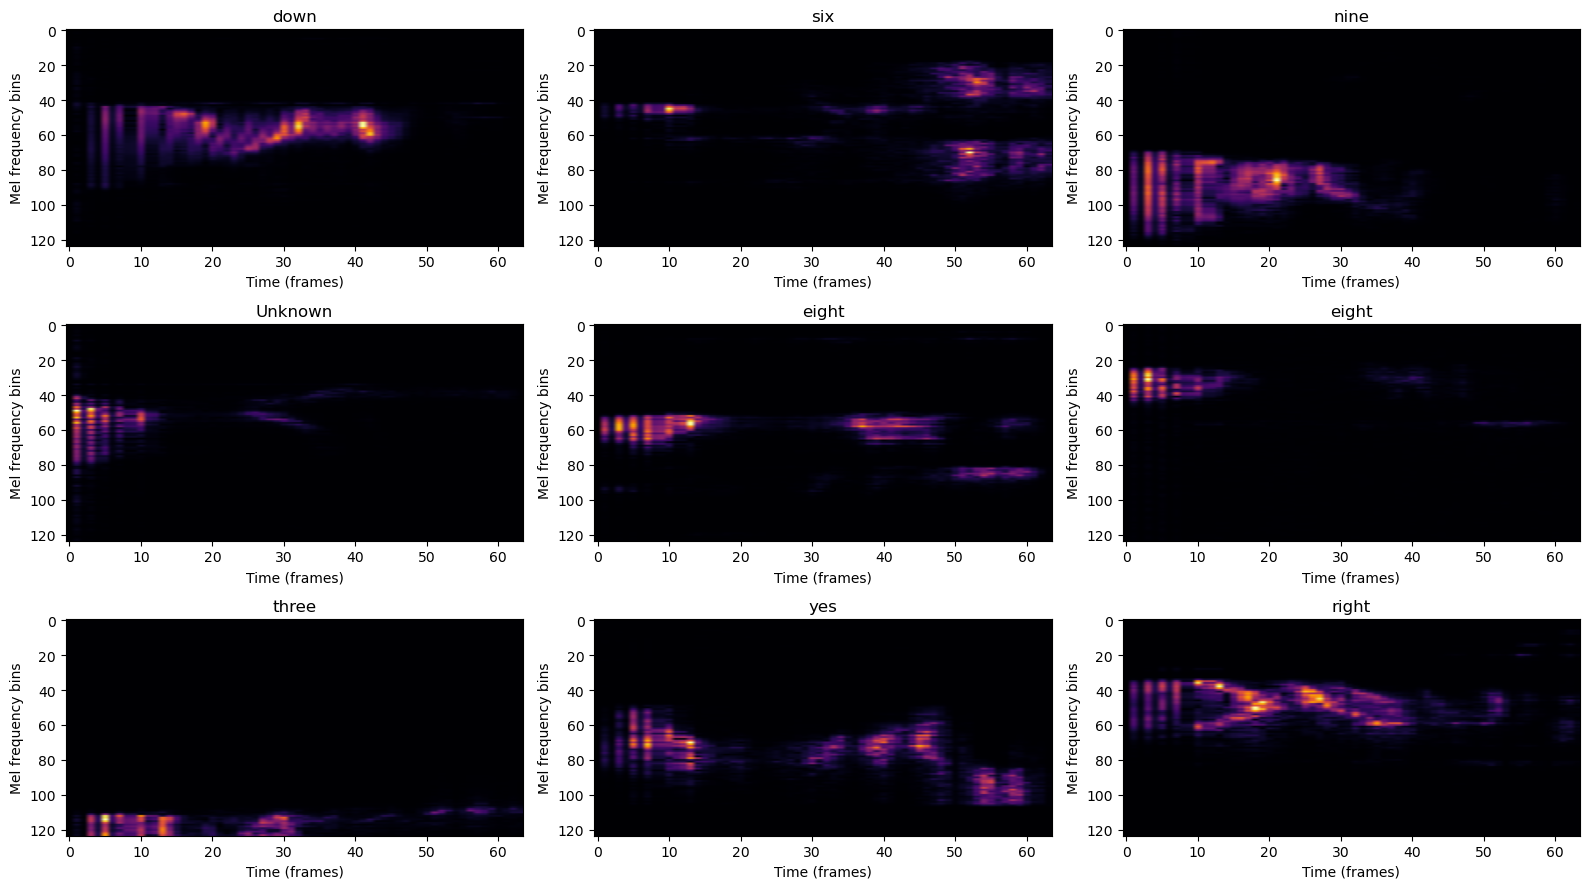

In [ ]:
for example_spectrograms, example_spect_labels in train_spectro_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    # Plot the mel spectrogram directly from the example_spectrograms
    ax.imshow(np.squeeze(example_spectrograms[i].numpy()), aspect='auto', cmap='inferno')
    # Get the label index (where the value is 1.0)
    label_idx = tf.argmax(example_spect_labels[i]).numpy()
    ax.set_title(label_names[label_idx])
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel frequency bins')

plt.tight_layout()
plt.show()

TODO: tähän jotain kivaa spektrogrammoista

## Treenaus

In [ ]:
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:
train_spectro_ds = train_spectro_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_spectro_ds = val_spectro_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_spectro_ds = test_spectro_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
print("Number of classes in dataset:", len(label_names))

Number of classes in dataset: 26


256 konvoluutio ei juurikaan vaikuttanut mallin suoritukseen, mutta hidasti koulutusta

In [ ]:
def train_model(train_ds, val_ds, test_ds, label_names, epochs=3, batch_size=32, learning_rate=0.001):
    import keras.layers as layers
    import keras.models as models
    import tensorflow as tf
    import matplotlib.pyplot as plt

    # Prepare datasets with caching and prefetching
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Get input shape and number of labels
    for example_spectrograms, _ in train_ds.take(1):
        input_shape = example_spectrograms.shape[1:]
    num_labels = len(label_names)

    # Normalize the data
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

    # Build the model
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation='softmax'),
    ])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'],
    )

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )

    # Plot training history
    metrics = history.history
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.show()

    # Evaluate the model on the test dataset
    test_results = model.evaluate(test_ds, return_dict=True)
    print("Test results:", test_results)

    return model, history

Epoch 1/15
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.4254 - loss: 1.9564 - val_accuracy: 0.8243 - val_loss: 0.6020
Epoch 2/15
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.7320 - loss: 0.8697 - val_accuracy: 0.8614 - val_loss: 0.4657
Epoch 3/15
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - accuracy: 0.7881 - loss: 0.6830 - val_accuracy: 0.8733 - val_loss: 0.4116
Epoch 4/15
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - accuracy: 0.8213 - loss: 0.5778 - val_accuracy: 0.8792 - val_loss: 0.3850
Epoch 5/15
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - accuracy: 0.8396 - loss: 0.5149 - val_accuracy: 0.8851 - val_loss: 0.3773
Epoch 6/15
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.8527 - loss: 0.4680 - val_accuracy: 0.8940 - val_loss: 0.3605
Epoch 7/15
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.8635 - loss: 0.4297 - val_accuracy: 0.8962 - val_loss: 0.3450
Epoch 8/15
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.8722 -

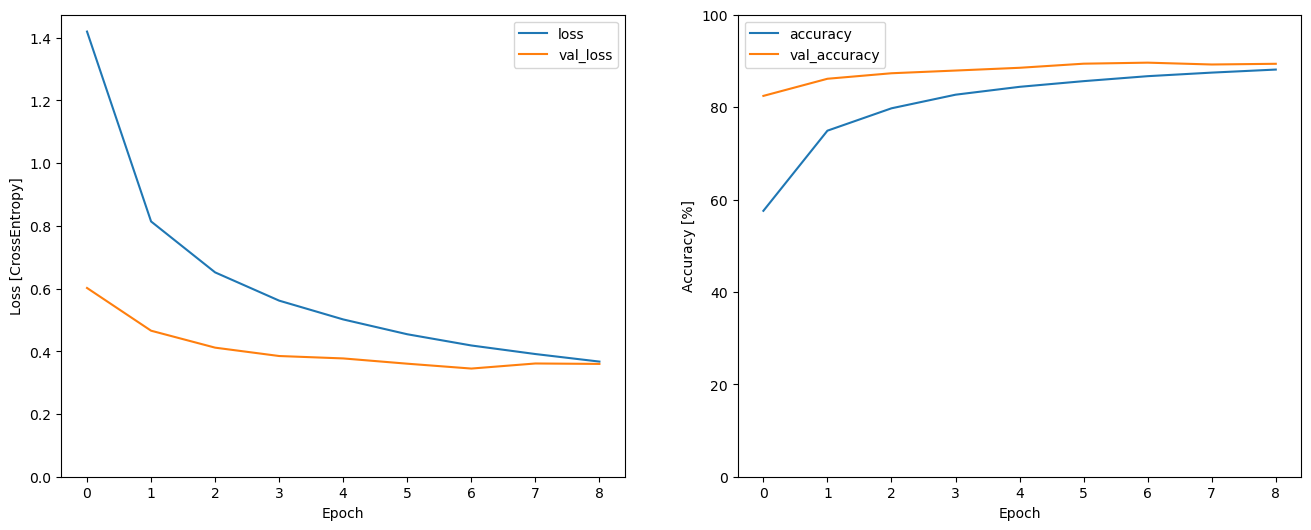

297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8903 - loss: 0.3727
Test results: {'accuracy': 0.8880000114440918, 'loss': 0.38364899158477783}


In [ ]:
trained_model, training_history = train_model(train_spectro_ds, val_spectro_ds, test_spectro_ds, label_names, epochs=15, batch_size=64)

297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


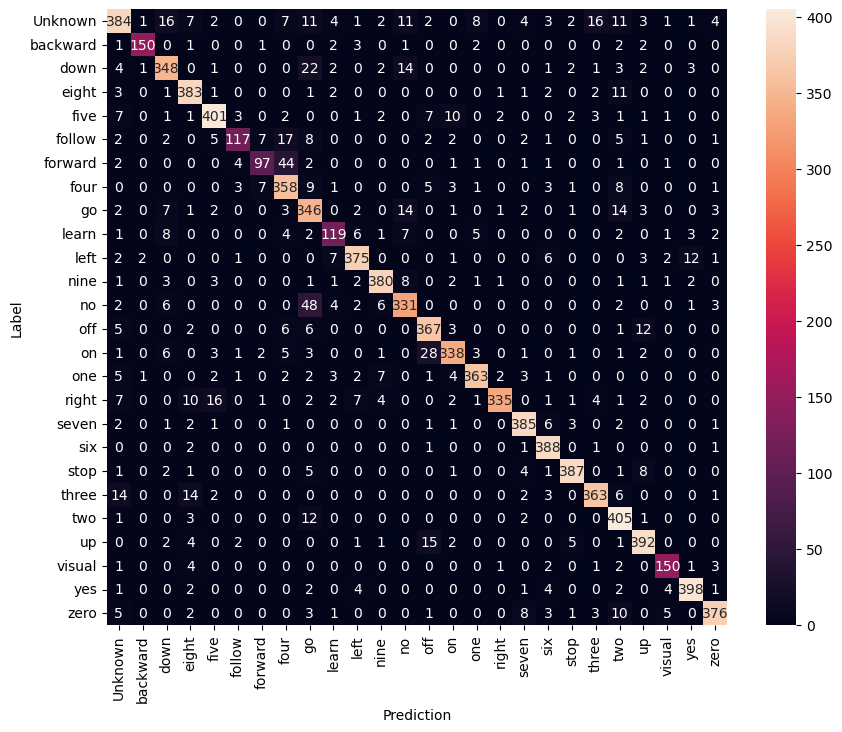

In [ ]:
# Confusion matrix for the final model
y_pred = trained_model.predict(test_spectro_ds)
y_true = tf.concat(list(test_spectro_ds.map(lambda s, lab: tf.argmax(lab, axis=1))), axis=0)
y_pred = tf.argmax(y_pred, axis=1)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Tallennetaan hyvä malli

In [ ]:
# Tallennetaan
trained_model.save('speech_command_model_toka.keras')

## Testataan mallia omilla äänitteillä
- Nauhoitimme muutamia äänitiedostoja, ja luokittelimme ne.

In [ ]:
import tensorflow as tf
import keras
import keras.utils
import numpy as np
import pathlib

In [ ]:
# Functions:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

def get_mel_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Convert to mel scale
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=64,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=16000,
        lower_edge_hertz=0,
        upper_edge_hertz=8000)
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(mel_spectrogram.shape[-1:]))
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    return mel_spectrogram

def make_spectro_dataset(ds, spectrogram_fn):
    return ds.map(lambda audio, labels: (spectrogram_fn(audio), labels),
                  num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Load dataset
own_sound_db = keras.utils.audio_dataset_from_directory(
    'omat_aanet',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)

trained_labels = ['Unknown', 'backward', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
                  'learn', 'left', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'six', 'stop',
                  'three', 'two', 'up', 'visual', 'yes', 'zero']

# Get the inferred class names
inferred_labels = own_sound_db.class_names
print("Inferred labels:", inferred_labels)

# Create a mapping from new labels to indices in the trained labels
label_mapping = {label: trained_labels.index(label) for label in inferred_labels}

# Function to remap labels
def remap_labels(audio, labels):
    # Find the active label index in the new dataset
    active_label_idx = tf.argmax(labels, axis=-1)
    
    # Map the active label index to the corresponding index in the trained labels
    new_label_idx = tf.gather(list(label_mapping.values()), active_label_idx)
    
    # Create a new one-hot encoded label with 26 classes
    new_label = tf.one_hot(new_label_idx, depth=len(trained_labels))
    return audio, new_label

# Apply the remapping to the dataset
own_sound_db = own_sound_db.map(remap_labels, tf.data.AUTOTUNE)

# Verify the remapped labels
for example_audio, example_labels in own_sound_db.take(1):
    print("Example audio shape:", example_audio.shape)
    print("Example labels shape:", example_labels.shape)
    print("Example labels:", example_labels[0])  # Print the label of the first example

def stereo_to_mono(audio, labels):
    # Reduce the last dimension (channels) by averaging, regardless of batch size
    audio = tf.reduce_mean(audio, axis=-1)
    return audio, labels

# Apply the stereo-to-mono conversion
own_sound_db = own_sound_db.map(stereo_to_mono, tf.data.AUTOTUNE)

# Verify the audio shape after conversion
for example_audio, example_labels in own_sound_db.take(1):
    print("Example audio shape after mono conversion:", example_audio.shape)
    print("Example labels shape:", example_labels.shape)


# Create spectrogram dataset
own_sound_spectro_db = make_spectro_dataset(own_sound_db, get_mel_spectrogram)
own_sound_spectro_db = own_sound_spectro_db.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify the spectrogram shape
for example_spectrograms, example_spect_labels in own_sound_spectro_db.take(1):
    print("Example spectrogram shape:", example_spectrograms.shape)
    print("Example labels shape:", example_spect_labels.shape)
    print("Example labels:", example_spect_labels[0])  # Print the label of the first example


# Load the trained model
model = keras.models.load_model('speech_command_model_toka.h5')

# Evaluate the model on the new dataset
loss, accuracy = model.evaluate(own_sound_spectro_db, verbose=1)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Found 17 files belonging to 6 classes.
Inferred labels: ['Unknown', 'no', 'one', 'seven', 'stop', 'yes']
Example audio shape: (17, 16000, 2)
Example labels shape: (17, 26)
Example labels: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)
Example audio shape after mono conversion: (17, 16000)
Example labels shape: (17, 26)


Example spectrogram shape: (17, 124, 64, 1)
Example labels shape: (17, 26)
Example labels: tf.Tensor(
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6471 - loss: 2.0554
Loss: 2.055434465408325, Accuracy: 0.6470588445663452


##

## Analyysi

#### Valmiin testisetin tunnistus

Ohjelma osaa tunnistaa ääniä testidatasta hyvin. Tarkkuus on n. 85-90 %.
Isoimmat erheet näkyvät konfuusiomatriisista. 
Malli paikoitellen tunnisti sanan "no" sanana "go".
Toinen huomattava erhe on sanan "forward" tunnistaminen sanana "four".
Kumpikin virhe on ymmärrettävä, koska sanat kuulostavat aika samalta.
Sanat "no" ja "forward" tunnistettiin pääasiassa myös oikein kuten matriisista näkee.

#### Omien sanojen tunnistus

Tällä hetkellä malli ei osaa hirveän hyvin tunnistaa meidän omia sanoja. Yritämme korjata mallia vielä.